In [1]:
# Load libraries and check memory

import psutil ; print(list(psutil.virtual_memory())[0:2])

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle

import gc
gc.collect()
print(list(psutil.virtual_memory())[0:2])

[17045868544, 6435102720]
[17045868544, 6333960192]


In [2]:
# Original data available from:
# https://www.kaggle.com/dalpozz/creditcardfraud

#data = pd.read_csv("creditcard.csv")
#print(data.shape)
#print(data.columns)
#data.head(3)

data = pickle.load(open('data/' + 'credicard.engineered.pkl','rb'))

# data columns will be all other columns except class
data_cols = list(data.columns[ data.columns != 'Class' ])
label_cols = ['Class']

print(data_cols)
print('# of data columns: ',len(data_cols))

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
# of data columns:  30


In [3]:
# 284315 normal transactions (class 0)
# 492 fraud transactions (class 1)

data.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

C:\Users\Kwandas\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\Kwandas\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


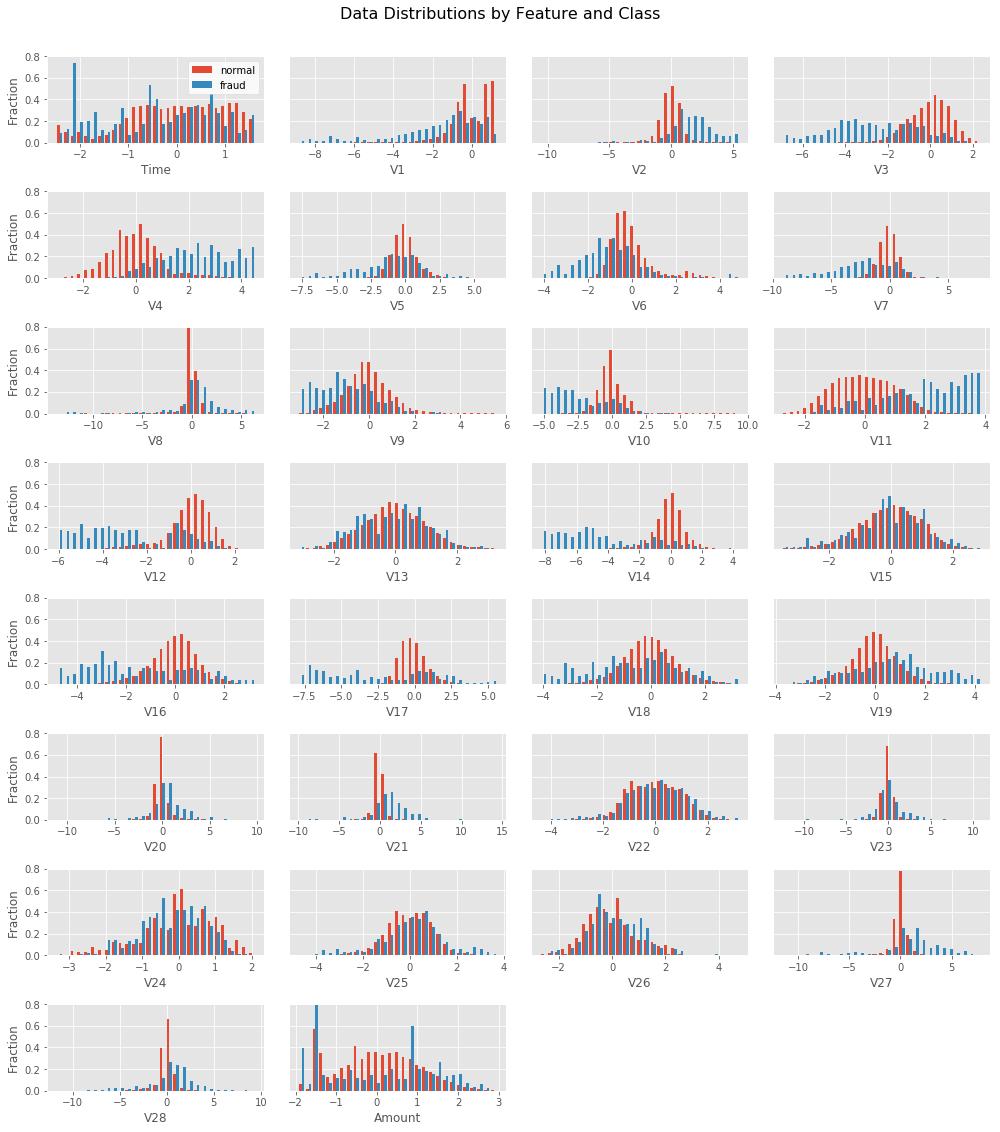

In [4]:
# Plot the data by each feature

axarr = [[]]*len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data.Class == 0, col ], data.loc[ data.Class == 1, col ] ], label=['normal','fraud'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30 ),
                          normed=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/Engineered_Data_Distributions.png')
plt.show()

In [6]:

# define the columns we want to test on, in case we want to use less than the full set

test_cols = data.columns

# test_cols = data.columns[ data.columns != 'Amount' ]

print(len(test_cols))
print(test_cols)

31
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [10]:
# metrics

from sklearn.metrics import recall_score, precision_score, roc_auc_score

def BaseMetrics(y_pred,y_true):
    TP = np.sum( (y_pred == 1) & (y_true == 1) )
    TN = np.sum( (y_pred == 0) & (y_true == 0) )
    FP = np.sum( (y_pred == 1) & (y_true == 0) )
    FN = np.sum( (y_pred == 0) & (y_true == 1) )
    return TP, TN, FP, FN

def SimpleMetrics(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    
    # Reporting
    from IPython.display import display
    print( 'Confusion Matrix')
    display( pd.DataFrame( [[TN,FP],[FN,TP]], columns=['Pred 0','Pred 1'], index=['True 0', 'True 1'] ) )
    print( 'Accuracy : {}'.format( ACC ))
    
def SimpleAccuracy(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    return ACC

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

In [8]:
# Set up the test and train sets

np.random.seed(0)

n_real = np.sum(data.Class==0) # 200000
n_test = np.sum(data.Class==1) # 492
train_fraction = 0.75
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_real, n_test )
print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

classes 0, 1:  284315 492
train, test:  213605 71202


C:\Users\Kwandas\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Kwandas\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [13]:
# Run the xgboost algorithm, maximize recall on the test set

results_dict = {}

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_true = test_df['Class'].values
print( 'best iteration: ', xgb_test.best_iteration )
print( recall( y_pred, dtest ) )
print( precision( y_pred, dtest ) )
print( roc_auc( y_pred, dtest ) )


best iteration:  22
('recall', 0.7886178861788617)
('precision', 0.941747572815534)
('roc_auc', 0.9772873810281175)


In [14]:
print( 'Accuracy: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)) )
SimpleMetrics( np.round(y_pred), y_true)

Accuracy: nan
Confusion Matrix


C:\Users\Kwandas\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars


,Pred 0,Pred 1
True 0,71073,6
True 1,26,97


Accuracy : 0.9995505744220669


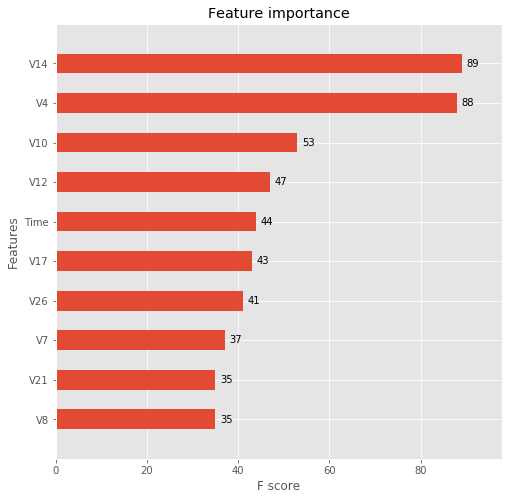

In [15]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=10, height=0.5, ax=ax);